# **1. Introduction** <a class="anchor" id="1"></a>

## **1.2. Import packages**

In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import math
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_profiling import ProfileReport
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
# Feature selection
from sklearn.feature_selection import VarianceThreshold

from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

from sklearn import random_projection

from scipy.cluster.hierarchy import dendrogram


## **1.3. Import data**

In [2]:
data = pd.read_csv('donors.csv',index_col='CONTROLN', low_memory=False)
print("The data set has total %d records and %d features" %data.shape)

The data set has total 95412 records and 475 features


## 1.4. Functions for the analysis

In [3]:
def unique_check_categorical(df, threshold):
    table = df.describe(include=['O'])
    highly_unique = []
    for col in table.columns:
        f = table.loc['freq',col]/table.loc['count',col]
        if f > threshold:
            highly_unique.append(col)
            print(col, ', percentage of top unique value = %.2f %%' %(100*f))
    if len(highly_unique) == 0:
        print('There is no column has too high percentage of a value')


def unique_check_numerical(df, threshold):
    variables_detected = []
    for i in df:
        if (df[i].value_counts()[0] / len(df)) > threshold:
            variables_detected.append(i)
    return variables_detected


#find features with correlations greater than 0.9 in order to remove them
def correlation_check(df, limit = 0.90, drop = False):
    corr = df.corr()
    mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
    corr_no_diag = corr.where(mask)
    coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]
    if drop is True:        
        df.drop(coll,axis = 1,inplace=True)
        print('Dropped:', coll)
        return df
    else:
        print('Columns having high correlation:', coll)  


# checking the value counts
def check_value_counts(df):
    for i in df:
        print(i)
        print(df[i].value_counts())
        print('-------------------')

In [4]:
def boxplot_func(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set()
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(16,4*rows))
  
    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.boxplot(data=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    
    # Finalize the plot
    plt.subplots_adjust(wspace=2,hspace = 0.5)
    fig.suptitle("Box plots", fontsize=25)
    sns.despine(bottom=True)
    plt.show()
    
def histplot_func(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set()
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(24,2*rows))
       
    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.histplot(data=df.loc[:,i[1]], bins=20,ax=i[0])
        i[0].set_xlabel(i[1])
        i[0].set_ylabel("")
      
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Histograms", fontsize=15)
    sns.despine(bottom=True)
    plt.show()
    
def corrheatmap(dataframe):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr() #Getting correlation of numerical variables

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, annot=True,annot_kws={"fontsize":10}, linewidths=.5,vmin = -1, vmax = 1, ax=ax)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()

# **2. Pre-processing data:** <a class="anchor" id="1"></a>

After conducting **Exploratory Data Analysis (Appendix 1)** for 475 features of the original data set, we have listed out the most significant features that we consider to be important for the clustering task.  
Thus, from now, we will continue with these selected features:

In [5]:
# Import the database we create for selecting the features:
features_list = pd.read_csv('Selected_Features.csv',index_col=0)
features_list.head()

,FeaturesName,Description,Category,SubCategory,Selected
Index,,,,,
1,ODATEDW,Origin Date. Date of donor's first gift,Characteristics,NaN,x
2,OSOURCE,Origin Source,Characteristics,NaN,x
3,TCODE,Donor title code,Characteristics,NaN,x
4,STATE,State abbreviation (a nominal/symbolic field),Characteristics,NaN,x
5,ZIP,Zipcode (a nominal/symbolic field),Characteristics,NaN,x


In [6]:
# Get the selected features
selected_feats = features_list[features_list['Selected'] == 'x']['FeaturesName']
df = data[selected_feats].copy()
df.dtypes

# function to update slected features dataframe everytime we adjust the data
def update_selected_feats_list(df, features_list):
    selected_feats = features_list.loc[features_list['FeaturesName'].isin(df.columns),:]
    return selected_feats

## **Feature engineering:** <a class="anchor" id="1"></a>


### **2.1. Getting the Age of every donor:** <a class="anchor" id="1"></a>

We notice that there is one feature called DOB - Day of Birth of the donors, so we thought it would we useful to generate the age of the donors as one feature. The donor's age will be measured at the time the donor received the most recent promotion which is recorded in 'MAXADATE' feature.

In [7]:
df['DOB'].head()

CONTROLN
95515     1957-12-01
148535    1972-02-01
15078            NaN
172556    1948-01-01
7112      1940-01-01
Name: DOB, dtype: object

In [8]:
#converting the DOB column to datetime type
parsed_dates = pd.to_datetime(df.DOB, format='%Y-%m-%d' , errors='coerce') #errors='coerce' meant to return NaN in case of exception
df['DOB'] = parsed_dates
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'], format='%Y-%m-%d' , errors='coerce')
# Getting the age of every donor today
df['AGE'] = ((df['MAXADATE'] - df['DOB']).dt.days/365).floordiv(other=1).astype('int',errors='ignore')

# Append new features to the feature list
feats = pd.DataFrame([['AGE', "Age of the donor","Characteristics","","x" ]],
                    columns=features_list.columns)
features_list= features_list.append(feats,ignore_index=True)

# Now, drop de DOB column as it is no longer useful
df.drop('DOB',inplace=True,axis = 1)

<AxesSubplot:>

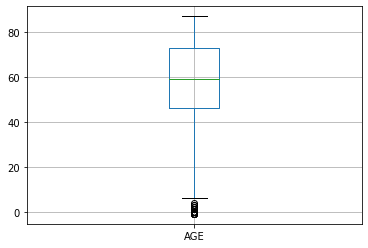

In [9]:
# Check for the box plot and distribution
df.boxplot(['AGE'])
# Here we can see that we have outliers, we will access this in the up coming session

### **2.2. Converting binary features of mailing activity:** <a class="anchor" id="1"></a>

There are features containing binary information but they are not in the right data type for processing, so we convert them to binary type

In [10]:
df.loc[:, 'COLLECT1':'PLATES'].head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
CONTROLN,,,,,,,,,,,,,,,,,,
95515,,,,,,,,,,,,,,,,,,
148535,,,,,,,,,,,,,,,,,,
15078,,,,,,,,,,,,,,,,,,
172556,,,,,,,,,,,,,,,,,,
7112,,,Y,Y,,,,Y,,,Y,,Y,,Y,,Y,


In [11]:
#Replace the values for booleans
df.loc[:, 'COLLECT1':'PLATES'] = df.loc[:, 'COLLECT1':'PLATES'].replace(' ',0)
df.loc[:, 'COLLECT1':'PLATES'] = df.loc[:, 'COLLECT1':'PLATES'].replace('Y',1)
df.loc[:, 'COLLECT1':'PLATES'].head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
CONTROLN,,,,,,,,,,,,,,,,,,
95515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148535,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
172556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7112,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0


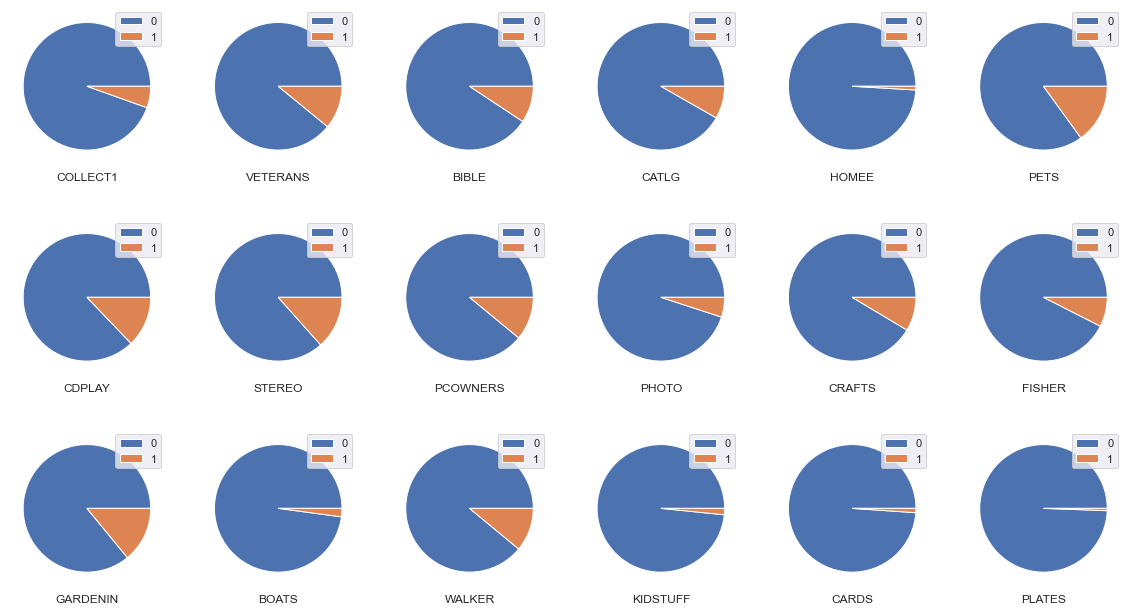

In [12]:
# Plot the result
plotdf = df.loc[:, 'COLLECT1':'PLATES'].apply(pd.value_counts)
#plot pie charts for all the interests
sns.set()
fig, axes = plt.subplots(3, ceil(len(plotdf.columns.to_list()) / 3), figsize=(20,11))
for ax, feat in zip(axes.flatten(), plotdf.columns.to_list()):
    ax.pie(plotdf[feat])
    ax.set_title(feat, y=-0.13)
    ax.legend(plotdf.index)
plt.show() 

### **2.3. Generate RFA status of the each donor before they are considered to be Lapsed Donor:** <a class="anchor" id="1"></a>

Because all the donors which is investigated in this dataset is all Lapsed Donors as the date of the lasted promotion, so we will not able to undestand the 'Recency' charateristics if we only consider the most recent code of the donor (all 'Lapsed').  

Therefore, we thought it would be interesting if we get the most recent type of code of each donor before they are considered to become Lapsed Donors

We will consider the data in features **Donor's RFA status as of XXXX promotion date (XXXX is from 'RFA_3'to 'RFA_24')**

In [13]:
# Replace the blank values with NaN value
df.loc[:,'RFA_3':'RFA_24'] = df.loc[:,'RFA_3':'RFA_24'].replace({' ' : np.NaN})
# Find the second most recent type of a donor by the left-most available values from RFA_3 to RFA_24
df['RFA_USEDTO'] = df.loc[:,'RFA_3':'RFA_24'].fillna(method = 'bfill',axis = 1)['RFA_3']
# Renerate R, F, A features
df['RFA_USEDTO_R'] = df['RFA_USEDTO'].apply(lambda x: str(x)[0])
df['RFA_USEDTO_F'] = df['RFA_USEDTO'].apply(lambda x: str(x)[1])
df['RFA_USEDTO_A'] = df['RFA_USEDTO'].apply(lambda x: str(x)[2])

# Add to the selected features list
feats = pd.DataFrame([['RFA_USEDTO_R', "Recency code of the previous status of the donor","Promotion and Gift","","x" ],
                    ['RFA_USEDTO_F', "Frequency code of the previous status of the donor","Promotion and Gift","","x"], 
                    ['RFA_USEDTO_A', "Amount code of the previous status of the donor","Promotion and Gift","","x"]],
                    columns=features_list.columns)
features_list= features_list.append(feats,ignore_index=True)

# Now drop the features that is no longer useful
df.drop(labels='RFA_USEDTO',axis=1,inplace = True, errors='ignore')
# Check for the result
df.loc[:,'RFA_USEDTO_R':'RFA_USEDTO_A'].head()

,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A
CONTROLN,,,
95515,S,4,E
148535,A,2,G
15078,S,4,E
172556,S,4,E
7112,A,2,F


In [14]:
# Drop the RFA status of donor as they are no longer useful
df.drop(labels=df.loc[:,'RFA_3':'RFA_24'].columns,axis=1,inplace=True,errors='ignore')
df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,...,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,AGE,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,2009-01-01,GRI,0,IL,61081,,XXXX,T2,,,...,4,E,X,X,X,C,59.0,S,4,E
148535,2014-01-01,BOA,1,CA,91326,,XXXX,S1,H,,...,2,G,X,X,X,A,45.0,A,2,G
15078,2010-01-01,AMH,1,NC,27017,,XXXX,R2,U,,...,4,E,X,X,X,C,NaN,S,4,E
172556,2007-01-01,BRY,0,CA,95953,,XXXX,R2,U,,...,4,E,X,X,X,C,69.0,S,4,E
7112,2006-01-01,,0,FL,33176,,XXXX,S2,H,,...,2,F,X,X,X,A,77.0,A,2,F


### Now we have 158 features

In [15]:
selected_feats = features_list.loc[features_list['FeaturesName'].isin(df.columns),:]
selected_feats.head()

,FeaturesName,Description,Category,SubCategory,Selected
0,ODATEDW,Origin Date. Date of donor's first gift,Characteristics,NaN,x
1,OSOURCE,Origin Source,Characteristics,NaN,x
2,TCODE,Donor title code,Characteristics,NaN,x
3,STATE,State abbreviation (a nominal/symbolic field),Characteristics,NaN,x
4,ZIP,Zipcode (a nominal/symbolic field),Characteristics,NaN,x


In [16]:
# Summary by category
pd.DataFrame(selected_feats.groupby('Category')['FeaturesName'].count())

,FeaturesName
Category,
Characteristics,23
Interests,19
Mail response,14
Neighborhood,75
Promotion and Gift,27


# **3. Data cleaning:** <a class="anchor" id="1"></a>

In [17]:
df

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,...,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,AGE,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,2009-01-01,GRI,0,IL,61081,,XXXX,T2,,,...,4,E,X,X,X,C,59.0,S,4,E
148535,2014-01-01,BOA,1,CA,91326,,XXXX,S1,H,,...,2,G,X,X,X,A,45.0,A,2,G
15078,2010-01-01,AMH,1,NC,27017,,XXXX,R2,U,,...,4,E,X,X,X,C,NaN,S,4,E
172556,2007-01-01,BRY,0,CA,95953,,XXXX,R2,U,,...,4,E,X,X,X,C,69.0,S,4,E
7112,2006-01-01,,0,FL,33176,,XXXX,S2,H,,...,2,F,X,X,X,A,77.0,A,2,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184568,2016-01-01,ASE,1,AK,99504,,XXXX,C2,,,...,1,G,X,X,X,C,NaN,F,1,G
122706,2016-01-01,DCD,1,TX,77379,,XXXX,C1,H,,...,1,F,X,X,X,A,47.0,P,1,F
189641,2015-01-01,MBC,1,MI,48910,,XXXX,C3,,,...,3,E,X,X,X,B,59.0,S,4,E


## 3.1. Check for features interpretability:

In this section, we will access the ability to interpret the feature based on its description, number of unique values and nulls values.  
We also try to engineer some features for better interpretation

### 3.1.1. Characteristics features:

In [18]:
selected_feats[selected_feats['Category'] == 'Characteristics']

,FeaturesName,Description,Category,SubCategory,Selected
0,ODATEDW,Origin Date. Date of donor's first gift,Characteristics,NaN,x
1,OSOURCE,Origin Source,Characteristics,NaN,x
2,TCODE,Donor title code,Characteristics,NaN,x
3,STATE,State abbreviation (a nominal/symbolic field),Characteristics,NaN,x
4,ZIP,Zipcode (a nominal/symbolic field),Characteristics,NaN,x
5,MAILCODE,Mail Code,Characteristics,NaN,x
13,MDMAUD,The Major Donor Matrix code,Characteristics,NaN,x
14,DOMAIN,DOMAIN/Cluster code. A nominal or symbolic field.,Characteristics,NaN,x
15,HOMEOWNR,Home Owner Flag,Characteristics,NaN,x
16,CHILD03,Presence of Children age 0-3,Characteristics,NaN,x


In [19]:
char_feats = selected_feats[selected_feats['Category'] == 'Characteristics']['FeaturesName']

In [20]:
df[char_feats]

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,...,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MAJOR,WEALTH2,GEOCODE,GEOCODE2,AGE
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,2009-01-01,GRI,0,IL,61081,,XXXX,T2,,,...,NaN,NaN,F,NaN,0,,5.0,,C,59.0
148535,2014-01-01,BOA,1,CA,91326,,XXXX,S1,H,,...,1.0,6.0,M,9.0,16,,9.0,02,A,45.0
15078,2010-01-01,AMH,1,NC,27017,,XXXX,R2,U,,...,NaN,3.0,M,1.0,2,,1.0,,C,NaN
172556,2007-01-01,BRY,0,CA,95953,,XXXX,R2,U,,...,NaN,1.0,F,4.0,2,,0.0,,C,69.0
7112,2006-01-01,,0,FL,33176,,XXXX,S2,H,,...,1.0,3.0,F,2.0,60,,NaN,,A,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184568,2016-01-01,ASE,1,AK,99504,,XXXX,C2,,,...,NaN,NaN,M,NaN,0,,NaN,,C,NaN
122706,2016-01-01,DCD,1,TX,77379,,XXXX,C1,H,,...,1.0,7.0,M,9.0,1,,NaN,,A,47.0
189641,2015-01-01,MBC,1,MI,48910,,XXXX,C3,,,...,NaN,NaN,M,NaN,0,,NaN,,B,59.0


**a) Feature engineering:**

There are some columns contain missing values but in different type of format rather than NaN format. Thus, in this section, we will replace them with numpy.NaN values for better processing:

In [21]:
df[char_feats].isin([' ']).sum(axis = 0)

ODATEDW         0
OSOURCE       928
TCODE           0
STATE           0
ZIP             0
MAILCODE    94013
MDMAUD          0
DOMAIN       2316
HOMEOWNR    22228
CHILD03     94266
CHILD07     93846
CHILD12     93601
CHILD18     92565
NUMCHLD         0
INCOME          0
GENDER       2957
WEALTH1         0
HIT             0
MAJOR       95118
WEALTH2         0
GEOCODE     80168
GEOCODE2      187
AGE             0
dtype: int64

In [22]:
# Except for MAILCODE where ' ' is actually a value, we will replace all other ' ' values as NaN
for col in df[char_feats].isin([' ']).sum(axis = 0).index:
    if col == 'MAILCODE':
        next
    else:
        df[col] = df[col].replace(' ', np.NaN)

In [23]:
#checking all the values for the Gender
#M = Male
#F = Female
#U = Unknown
#J = Joint Account
print(df['GENDER'].unique())

#replacing unknown values to 'U'
df['GENDER'].replace(' ','U',inplace=True)
df['GENDER'].replace('A','U',inplace=True)
df['GENDER'].replace('C','U',inplace=True)

#checking the difference
print(df['GENDER'].unique())

['F' 'M' nan 'C' 'U' 'J' 'A']
['F' 'M' nan 'U' 'J']


**b) Check for unique values:**

In [24]:
df[char_feats].describe(include=['O'])

,ODATEDW,OSOURCE,STATE,ZIP,MAILCODE,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,GENDER,MAJOR,GEOCODE,GEOCODE2
count,95412,94484,95412,95412,95412,95412,93096,73184,1146,1566,1811,2847,92455,294,15244,95093
unique,54,895,57,19938,2,28,16,2,3,3,3,3,4,1,7,4
top,2015-01-01,MBC,CA,85351,,XXXX,R2,H,M,M,M,M,F,X,12,A
freq,15358,4539,17343,61,94013,95118,13623,52354,869,1061,1149,1442,51277,294,3914,34484


In [25]:
unique_check_categorical(df[char_feats], 0.9)

MAILCODE , percentage of top unique value = 98.53 %
MDMAUD , percentage of top unique value = 99.69 %
MAJOR , percentage of top unique value = 100.00 %


In [26]:
#columns are not interesting and have lots of null values
df.drop(['MAILCODE','MDMAUD','CHILD03','CHILD07','CHILD12','CHILD18','MAJOR'],inplace=True,axis = 1)
# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
char_feats = selected_feats[selected_feats['Category'] == 'Characteristics']['FeaturesName']

**c) Check for correlation**

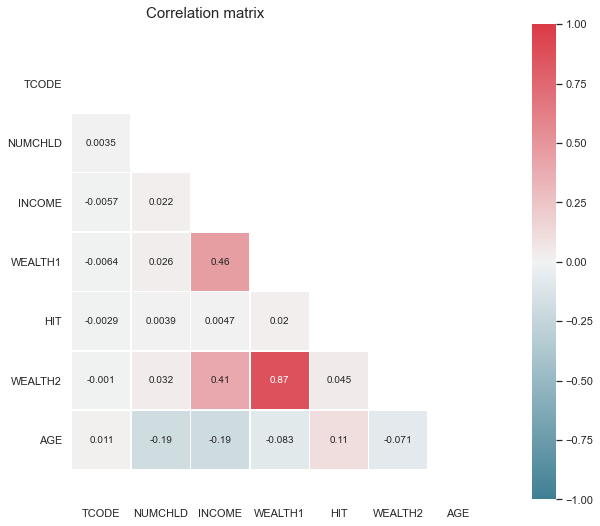

In [27]:
corrheatmap(df[char_feats])

In [28]:
correlation_check(df[char_feats])

Columns having high correlation: []


**d) Check for Nulls values:**

In [29]:
df[char_feats].isna().sum()

ODATEDW         0
OSOURCE       928
TCODE           0
STATE           0
ZIP             0
DOMAIN       2316
HOMEOWNR    22228
NUMCHLD     83026
INCOME      21286
GENDER       2957
WEALTH1     44732
HIT             0
WEALTH2     43823
GEOCODE     80168
GEOCODE2      319
AGE         23883
dtype: int64

Too many null values for NUMCHLD and GEOCODE so we will drop these columns

In [30]:
#too many null values for NUMCHLD and GEOCODE so we will drop these columns
df.drop(['NUMCHLD','GEOCODE'],inplace=True,axis = 1,errors='ignore')
# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
char_feats = selected_feats[selected_feats['Category'] == 'Characteristics']['FeaturesName']

In [31]:
# Summary by category
pd.DataFrame(selected_feats.groupby('Category')['FeaturesName'].count())

,FeaturesName
Category,
Characteristics,14
Interests,19
Mail response,14
Neighborhood,75
Promotion and Gift,27


### 3.1.2 Interests features

In [32]:
# selected features
selected_feats[selected_feats['Category'] == 'Interests']

,FeaturesName,Description,Category,SubCategory,Selected
52,COLLECT1,COLLECTABLE (Y/N),Interests,NaN,x
53,VETERANS,VETERANS (Y/N),Interests,NaN,x
54,BIBLE,BIBLE READING (Y/N),Interests,NaN,x
55,CATLG,SHOP BY CATALOG (Y/N),Interests,NaN,x
56,HOMEE,WORK FROM HOME (Y/N),Interests,NaN,x
57,PETS,HOUSEHOLD PETS (Y/N),Interests,NaN,x
58,CDPLAY,CD PLAYER OWNERS (Y/N),Interests,NaN,x
59,STEREO,STEREO/RECORDS/TAPES/CD (Y/N),Interests,NaN,x
60,PCOWNERS,HOME PC OWNERS/USERS,Interests,NaN,x
61,PHOTO,PHOTOGRAPHY (Y/N),Interests,NaN,x


In [33]:
interests_feats = selected_feats[selected_feats['Category'] == 'Interests']['FeaturesName']

df[interests_feats]

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC
CONTROLN,,,,,,,,,,,,,,,,,,,
95515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
148535,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
15078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
172556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
7112,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184568,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
122706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
189641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,


**a) Feature engineering:**

In [34]:
df[interests_feats].isin([' ']).sum(axis = 0)

COLLECT1        0
VETERANS        0
BIBLE           0
CATLG           0
HOMEE           0
PETS            0
CDPLAY          0
STEREO          0
PCOWNERS        0
PHOTO           0
CRAFTS          0
FISHER          0
GARDENIN        0
BOATS           0
WALKER          0
KIDSTUFF        0
CARDS           0
PLATES          0
LIFESRC     54032
dtype: int64

In [35]:
# We have blank space only in the variable LIFESRC (LIFE STYLE DATA SOURCE)
df['LIFESRC'] = df['LIFESRC'].replace(' ', np.NaN)

**b) Check for unique values:**

In [36]:
df[interests_feats].describe()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
count,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000
mean,0.054521,0.109273,0.092976,0.082432,0.009297,0.150149,0.128432,0.134092,0.109850,0.050161,0.085692,0.074729,0.140465,0.021255,0.110060,0.016099,0.010911,0.005869
std,0.227045,0.311984,0.290400,0.275023,0.095970,0.357219,0.334572,0.340753,0.312704,0.218279,0.279909,0.262954,0.347470,0.144235,0.312966,0.125855,0.103883,0.076386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
unique_check_categorical(df[interests_feats], 0.6)

There is no column has too high percentage of a value


In [38]:
unique_check_numerical(df[interests_feats], 0.9)

['COLLECT1',
 'BIBLE',
 'CATLG',
 'HOMEE',
 'PHOTO',
 'CRAFTS',
 'FISHER',
 'BOATS',
 'KIDSTUFF',
 'CARDS',
 'PLATES']

In [39]:
check_value_counts(df[interests_feats])

COLLECT1
0    90210
1     5202
Name: COLLECT1, dtype: int64
-------------------
VETERANS
0    84986
1    10426
Name: VETERANS, dtype: int64
-------------------
BIBLE
0    86541
1     8871
Name: BIBLE, dtype: int64
-------------------
CATLG
0    87547
1     7865
Name: CATLG, dtype: int64
-------------------
HOMEE
0    94525
1      887
Name: HOMEE, dtype: int64
-------------------
PETS
0    81086
1    14326
Name: PETS, dtype: int64
-------------------
CDPLAY
0    83158
1    12254
Name: CDPLAY, dtype: int64
-------------------
STEREO
0    82618
1    12794
Name: STEREO, dtype: int64
-------------------
PCOWNERS
0    84931
1    10481
Name: PCOWNERS, dtype: int64
-------------------
PHOTO
0    90626
1     4786
Name: PHOTO, dtype: int64
-------------------
CRAFTS
0    87236
1     8176
Name: CRAFTS, dtype: int64
-------------------
FISHER
0    88282
1     7130
Name: FISHER, dtype: int64
-------------------
GARDENIN
0    82010
1    13402
Name: GARDENIN, dtype: int64
-------------------
BOATS
0 

In [40]:
# dropping the variables with too many unique values = 0. It means that the interest is not that common, so probably no useful to detect clusters
df = df.drop(columns=['COLLECT1','BIBLE','CATLG','HOMEE','PHOTO','CRAFTS', 'FISHER','BOATS','KIDSTUFF','CARDS','PLATES'])

**c) Check for correlation:**

In [41]:
# updating the interest's list
interests_feats = ['VETERANS', 'PETS','CDPLAY', 'STEREO', 'PCOWNERS','GARDENIN', 'WALKER', 'LIFESRC']

In [42]:
correlation_check(df[interests_feats])

Columns having high correlation: []


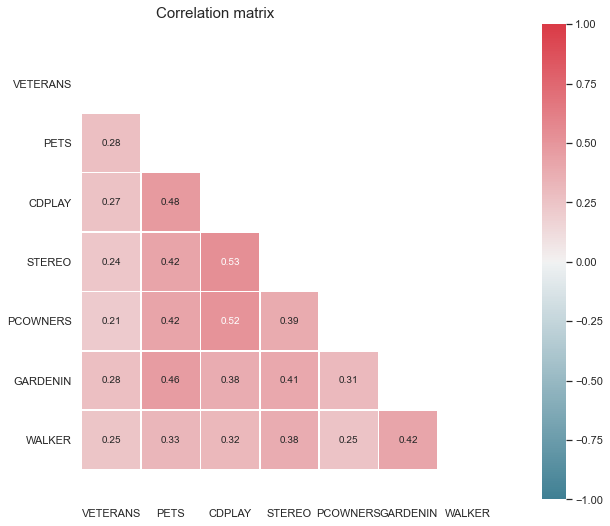

In [43]:
corrheatmap(df[interests_feats])

We have low correlations between these variables, that's goood

**d) Check for null values:**

In [44]:
df[interests_feats].isna().sum()

VETERANS        0
PETS            0
CDPLAY          0
STEREO          0
PCOWNERS        0
GARDENIN        0
WALKER          0
LIFESRC     54032
dtype: int64

In [45]:
# We have many Nan values for the variable LIFESRC, so we decide to drop also this variable
df = df.drop(columns='LIFESRC')

### 3.1.3 Mail response features

In [46]:
# selected features
selected_feats[selected_feats['Category'] == 'Mail response']

,FeaturesName,Description,Category,SubCategory,Selected
25,MBCRAFT,Buy Craft Hobby,Mail response,NaN,x
26,MBGARDEN,Buy Gardening,Mail response,NaN,x
27,MBBOOKS,Buy Books,Mail response,NaN,x
28,MBCOLECT,Buy Collectables,Mail response,NaN,x
29,MAGFAML,Buy General Family Mags,Mail response,NaN,x
30,MAGFEM,Buy Female Mags,Mail response,NaN,x
31,MAGMALE,Buy Sports Mags,Mail response,NaN,x
32,PUBGARDN,Gardening Pubs,Mail response,NaN,x
33,PUBCULIN,Culinary Pubs,Mail response,NaN,x
34,PUBHLTH,Health Pubs,Mail response,NaN,x


In [47]:
mail_feats = selected_feats[selected_feats['Category'] == 'Mail response']['FeaturesName']

df[mail_feats]

,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP
CONTROLN,,,,,,,,,,,,,,
95515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148535,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
15078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
172556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7112,1.0,0.0,9.0,0.0,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122706,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**a) Feature engineering:**

**b) Check for unique values:**

In [48]:
df[mail_feats].describe()

,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP
count,42558.000000,42558.000000,42558.000000,42498.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000
mean,0.152075,0.059166,1.116382,0.063932,0.448329,0.126322,0.065722,0.141806,0.145237,0.714484,0.237723,0.376239,0.005874,0.237558
std,0.470023,0.262078,1.669967,0.297344,0.821010,0.380916,0.276398,0.490414,0.427822,1.249891,0.728572,0.959573,0.077942,0.878639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,4.000000,9.000000,6.000000,9.000000,5.000000,4.000000,5.000000,6.000000,9.000000,8.000000,9.000000,2.000000,9.000000


In [49]:
unique_check_numerical(df[mail_feats], 0.5)

[]

In [50]:
check_value_counts(df[mail_feats])

MBCRAFT
0.0    37707
1.0     3521
2.0     1079
3.0      215
4.0       33
5.0        2
6.0        1
Name: MBCRAFT, dtype: int64
-------------------
MBGARDEN
0.0    40286
1.0     2054
2.0      193
3.0       22
4.0        3
Name: MBGARDEN, dtype: int64
-------------------
MBBOOKS
0.0    21299
1.0    10371
2.0     4664
3.0     2465
4.0     1469
5.0      901
6.0      538
7.0      325
9.0      325
8.0      201
Name: MBBOOKS, dtype: int64
-------------------
MBCOLECT
0.0    40267
1.0     1837
2.0      324
3.0       54
4.0       11
5.0        4
6.0        1
Name: MBCOLECT, dtype: int64
-------------------
MAGFAML
0.0    29790
1.0     8468
2.0     2859
3.0     1007
4.0      332
5.0       77
6.0       17
7.0        7
9.0        1
Name: MAGFAML, dtype: int64
-------------------
MAGFEM
0.0    37845
1.0     4117
2.0      537
3.0       52
4.0        6
5.0        1
Name: MAGFEM, dtype: int64
-------------------
MAGMALE
0.0    40036
1.0     2287
2.0      199
3.0       32
4.0        4
Name: MAGMALE, dt

**c) Check for correlation:**

In [51]:
correlation_check(df[mail_feats])

Columns having high correlation: []


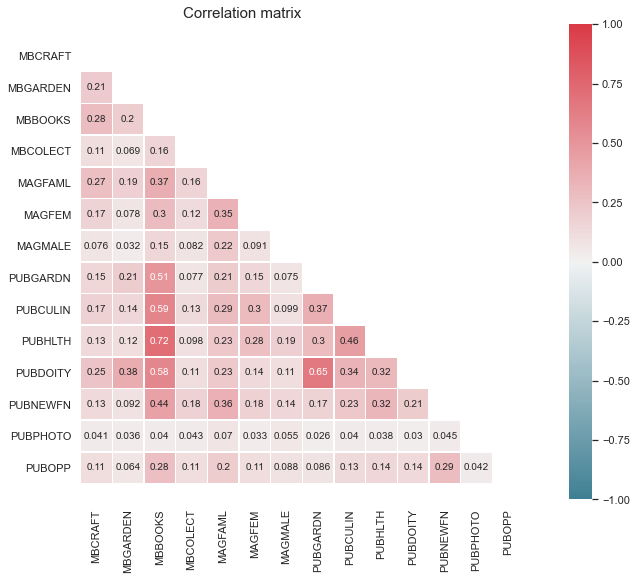

In [52]:
corrheatmap(df[mail_feats])

The highest correlation that we can notice in this heatmap is the one between the mail response for books and for public health. By the way, 0.72 is not too high. So we decide the keep both of them.

**d) Check for null values:**

In [53]:
df[mail_feats].isna().sum()

MBCRAFT     52854
MBGARDEN    52854
MBBOOKS     52854
MBCOLECT    52914
MAGFAML     52854
MAGFEM      52854
MAGMALE     52854
PUBGARDN    52854
PUBCULIN    52854
PUBHLTH     52854
PUBDOITY    52854
PUBNEWFN    52854
PUBPHOTO    52854
PUBOPP      52854
dtype: int64

In [54]:
# The percentages of the Nan are the same for all the variables, it means that we have the information of the mail reply only for a subset of our dataset
print(round(df[mail_feats].isna().sum()[0] / len(df), 3), '% of data dont have the information for all those variables')

0.554 % of data dont have the information for all those variables


By the way, for now we decide to keep these variables.

### 3.1.4. Promotion and Gift features:

In [55]:
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']
# selected features
selected_feats[selected_feats['Category'] == 'Promotion and Gift']

,FeaturesName,Description,Category,SubCategory,Selected
404,CARDPROM,Lifetime number of card promotions received to,Promotion and Gift,Summary,x
405,MAXADATE,Date of the most recent promotion received (in,Promotion and Gift,Summary,x
406,NUMPROM,Lifetime number of promotions received to date,Promotion and Gift,Summary,x
407,CARDPM12,Number of card promotions received in the last,Promotion and Gift,Summary,x
408,NUMPRM12,Number of promotions received in the last 12,Promotion and Gift,Summary,x
453,RAMNTALL,Dollar amount of lifetime gifts to date,Promotion and Gift,Summary,x
454,NGIFTALL,Number of lifetime gifts to date,Promotion and Gift,Summary,x
455,CARDGIFT,Number of lifetime gifts to card promotions to...,Promotion and Gift,Summary,x
456,MINRAMNT,Dollar amount of smallest gift to date,Promotion and Gift,Summary,x
457,MINRDATE,Date associated with the smallest gift to date,Promotion and Gift,Summary,x


**a) Feature engineering:**

There are 4 date-time features that we can assume that they will not have much interpretation power for clustering.  
Those features are: **'MINRDATE', 'MAXRDATE', 'NEXTDATE' and 'TIMELAG'**.  

Thus, we decided to drop them:

In [56]:
# Remove un-relevant features
df = df.drop(columns=['MINRDATE','MAXRDATE','NEXTDATE','TIMELAG'],errors='ignore')

The remaining date-time features are 'MAXADATE', 'LASTDATE' and 'FISTDATE'. These features are useful to generate two important features in RFM (Recency, Frequency and Monetary) analysis which are Recency and Frequency.  

The 2 new features to generate are:
- Time in days since the last promotion and the last gift from the donor: 'RECENCY' = 'MAXADATE' - 'LASTDATE'  
- Time in days since the last promotion and the first gift from the donor: 'LIFETIME' = 'MAXADATE' - 'FISTDATE' 

In [57]:
# convert data to datetime 
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'])
df['LASTDATE'] = pd.to_datetime(df['LASTDATE'])
df['FISTDATE'] = pd.to_datetime(df['FISTDATE'])
# measure the recency and lifetime of donors
df['RECENCY'] = (df['MAXADATE'] - df['LASTDATE'])/pd.to_timedelta(1, unit='D')
df['LIFETIME'] = (df['MAXADATE'] - df['FISTDATE'])/pd.to_timedelta(1, unit='D')

# Add new features to the metadata
feats = pd.DataFrame([['RECENCY', "Time in days since the last promotion and the last gift from the donor","Promotion and Gift","","x" ],
                    ['LIFETIME', "Time in days since the last promotion and the first gift from the donor","Promotion and Gift","","x"]], 
                    columns=selected_feats.columns)
features_list= features_list.append(feats,ignore_index=True)
                      
# Then we drop the datetime columns:
df = df.drop(columns=['MAXADATE','FISTDATE','LASTDATE'],errors='ignore')

# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']

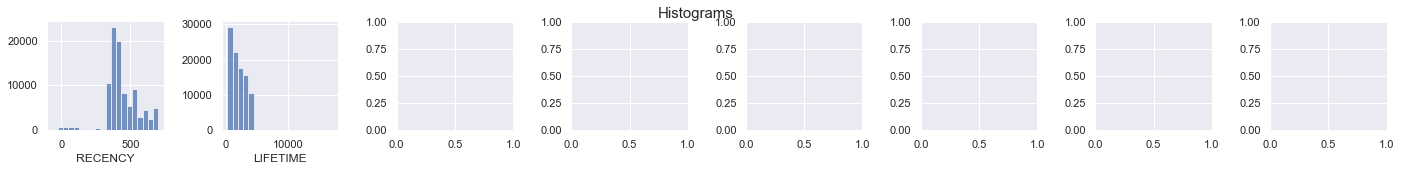

In [58]:
histplot_func(df.loc[:,['RECENCY','LIFETIME']])

**b) Check for unique values:**

In [59]:
df[PG_feats].describe(include=['O'])

,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A
count,95412,95412,95412,95412,95412,95412,95412,95412
unique,1,4,5,4,5,8,4,7
top,L,F,X,X,X,A,1,F
freq,95412,46964,95118,95118,95118,60156,48358,46170


In [60]:
unique_check_categorical(df[PG_feats], 0.9)

RFA_2R , percentage of top unique value = 100.00 %
MDMAUD_R , percentage of top unique value = 99.69 %
MDMAUD_F , percentage of top unique value = 99.69 %
MDMAUD_A , percentage of top unique value = 99.69 %


We can clearly see that features **'RFA_2R', 'MDMAUD_R', 'MDMAUD_F' and 'MDMAUD_A'** having only 1 values for mostly all of their records, thus they are considered redundant in this cluster analysis

In [61]:
# Drop these redundant columns
df = df.drop(columns=['RFA_2R', 'MDMAUD_R', 'MDMAUD_F','MDMAUD_A'],errors='ignore')
# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']

**c) Check for correlation**

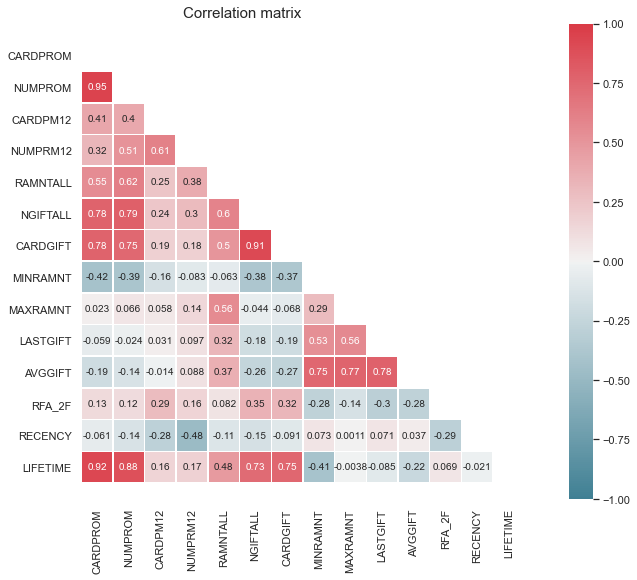

In [62]:
corrheatmap(df[PG_feats])

In [63]:
correlation_check(df[PG_feats])

Columns having high correlation: ['NUMPROM', 'CARDGIFT', 'LIFETIME']


In [64]:
# Drop these redundant columns
df = df.drop(columns=['NUMPROM', 'CARDGIFT', 'LIFETIME'])
# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']

**d) Check for Nulls values:**

In [65]:
df[PG_feats].isna().sum()

CARDPROM        0
CARDPM12        0
NUMPRM12        0
RAMNTALL        0
NGIFTALL        0
MINRAMNT        0
MAXRAMNT        0
LASTGIFT        0
AVGGIFT         0
RFA_2F          0
RFA_2A          0
RFA_USEDTO_R    0
RFA_USEDTO_F    0
RFA_USEDTO_A    0
RECENCY         0
dtype: int64

## 3.2. Check for outliners:

In [66]:
def IQR_OutlierRemover(df,column,n):
    #give the function the column that you want to filter and the IQR multiplicator    
    # Compute the IQR
    q1= df[column].quantile(0.25)
    q3= df[column].quantile(0.75)
    Iqr = q3 - q1

    # Compute upper and lower limit (lower_limit = Q1 -1.5*IQR | upper_limit = Q3 + 1.5*IQR)
    lower_lim = q1 - n*Iqr
    upper_lim = q3 + n*Iqr

    initial_len = df.shape[0]

    df = df[~((df[column] < lower_lim) | (df[column] > upper_lim))]

    len_afterremov = df.shape[0]

    print('Percentage of data kept after removing outliers:', np.round(len_afterremov / initial_len, 4))

    return df

In [67]:
df = IQR_OutlierRemover(df,'Age',2)

KeyError: 'Age'

In [ ]:
df = IQR_OutlierRemover(df,'POP901',12.5)

In [ ]:
df = IQR_OutlierRemover(df,'POP90C5',5)

In [ ]:
#Removing Outlier of some columns without getting rid of lots of data
df = IQR_OutlierRemover(df,'ETH1',5)
df = IQR_OutlierRemover(df,'ETH2',13)
df = IQR_OutlierRemover(df,'ETH3',10)
df = IQR_OutlierRemover(df,'ETH4',13)
df = IQR_OutlierRemover(df,'ETH5',12.5)
df = IQR_OutlierRemover(df,'ETH12',1.5)

## 3.3. 